### User identification with logistic regression (Kaggle competition)

In [23]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

Here we'll analyze the sequence of websites consequently visited by a particular person and try to predict whether this person is Alice or someone else. 

The data is coming from this [competition](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2).

First, read the training and test sets:

In [3]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=times)

train_df = train_df.sort_values(by='time1')

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


There are some empty values in the table, it means that some sessions contain less than ten websites. We'll replace empty values with 0. Also we'll load the websites dictionary and check what it looks like and how many websites there are:

In [5]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)


with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)


sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


#### Exploratory Data Analysis

Let's first check which websites in the training data set are the most visited. As you can see, these are mostly Google services:

In [6]:
top_sites = pd.Series(train_df[sites].values.flatten()).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


Now let's check which website Alice visits the most:

In [7]:
idx1 = pd.Series(train_df[train_df['target'] == 1][sites].values.flatten()).value_counts().head(1).index

sites_dict.loc[idx1]

,site
77,i1.ytimg.com


Overall, less than 1% of all sessions in the dataset belong to Alice:

In [8]:
len(train_df[train_df['target'] == 1]) / len(train_df)

0.00905896411514389

Now we only have data with the timestamps of attending the corresponding site. However, it might not be as informative. We can create new feature outlining the duration of each session: 

In [9]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


On average, Alice's session is shorter than that of other users according to descriptive statistics. However, minimum and maximum durations of Alice's and other users' sessions are approximately the same:

In [10]:
time_df.groupby('target').describe()

seconds                                                       
           count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0

### Training the first model

Preparing the data: 

In [11]:
y_train = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df])
idx_split = train_df.shape[0]

We are going to perform some transformations, which is easier to do for the whole united dataframe at once. That's why we concatenated both train and test data for now.

For the first basic model, we will use only the visited websites in the session. That is, the more often we see Alice's favourite (most visited) sites in the session, the higher probability that this is Alice's session.

In [12]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


We need to transform this dataframe so each website has a corresponding feature and its value is equal to number of this website visits in the session:

In [13]:
sites_flatten = full_sites.values.flatten()

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [14]:
full_sites_sparse.shape

(336358, 48371)

The first model is basic logistic regression. We will use the first 90% of the data for training and the remaining 10% for validation. 

Below is a simple function that returns the value of the metrics after training:

In [15]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    return score

In [16]:
%%time
X_train = full_sites_sparse[:idx_split, :]

print(get_auc_lr_valid(X_train, y_train))

0.9195247096744587
CPU times: user 9.02 s, sys: 180 ms, total: 9.2 s
Wall time: 5.7 s


The first model demonstrated the quality  of just under 0.92 on the test set.

In [17]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

First submission:

In [18]:
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

write_to_submission_file(y_test, 'submission_1.csv')


### Some feature Engineering

Now we are going to try to improve the quality of our model by adding new features to the data. 

In [19]:
full_new_feat = pd.DataFrame(index=full_df.index)

full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

Before adding the new feature to the training sample and checking the quality of the new model, it is better to scale it:

In [20]:
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.9196984641972088


The AUC value practically did not change. Let's try to add another feature - the number of the unique web-sites in a session:

In [21]:
full_new_feat['n_unique_sites'] = full_df[sites].replace(0, np.nan).nunique(axis = 1)

In [24]:
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.9161739344666173


So, the new feature has slightly decreased the quality, so we will not use it. 

Another two features might be useful: the hour at which the session started and the indicator of whether the session started in the morning:

In [25]:
full_new_feat = full_new_feat.drop('n_unique_sites', axis = 1)

In [26]:
full_new_feat['start_hour'] = pd.DatetimeIndex(full_df['time1']).hour

In [27]:
full_new_feat['morning'] = full_new_feat.start_hour.apply(lambda x: 1 if x < 12 else 0)

In [28]:
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.948779023496563


We managed to get a higher quality on the train data. However, not all additional variables were scaled here. Maybe it's better to scale all of them:

In [29]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]]))

score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9591490436406147


We got a higher AUC, but that's not all. We can try to beat this result by optimizing the regularization parameter (last time C = 1). We will take a list of possible values of C and calculate the quality metric on the test set for each of C-values:

In [30]:
from tqdm import tqdm

Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:36<00:00,  6.65s/it]


Plotting the graph of the quality metric versus the value of the regularization parameter:

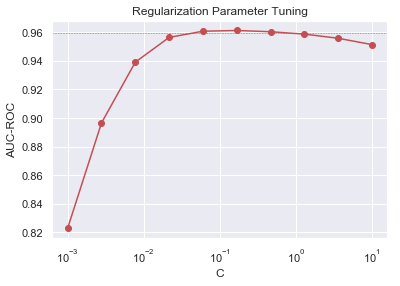

In [31]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
plt.axhline(y = score_C_1, linewidth = .5, color='b', linestyle='dashed') 
plt.show()

That is, the value of parameter C that corresponds to the highest model quality is appr. 0.17:

In [32]:
C = Cs[scores.index(max(scores))]
print(C)

0.1668100537200059


Lastly, we'll use the optimal regularization parameter to train the model and create new submission file. The final AUC is 0.9591:

In [33]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], tmp_scaled[idx_split:,:]]))

lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

y_test = lr.predict_proba(X_test)[:, 1]

In [34]:
print(get_auc_lr_valid(X_train, y_train))

0.9591490436406147


In [ ]:
write_to_submission_file(y_test, 'submission_2.csv')